In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycaret.classification as pc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import log_loss, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

import seaborn as sns
import copy


In [2]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")

exp_name = 'Projeto Kobe'
exp_kobe_project = mlflow.get_experiment_by_name(exp_name)
if exp_kobe_project is None:
    exp_id = mlflow.create_experiment(exp_name)
    exp_kobe_project = mlflow.get_experiment(exp_id)
exp_id = exp_kobe_project.experiment_id

2024/04/18 20:12:32 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/04/18 20:12:32 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

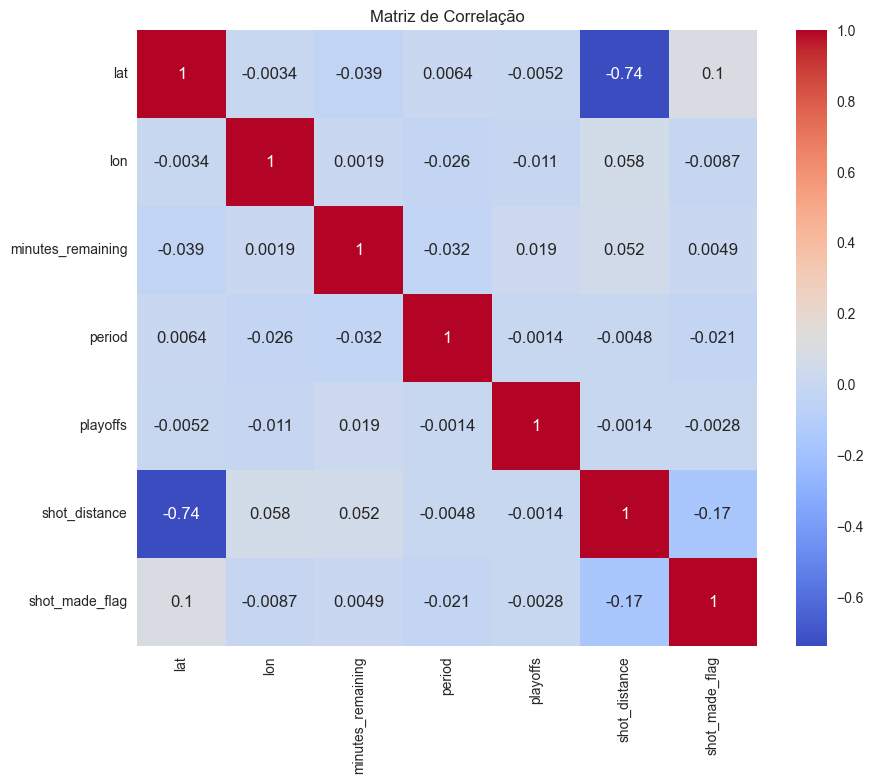

In [3]:
raw_data = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')
data_cols = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
target_col = 'shot_made_flag'
raw_data = raw_data[data_cols].copy()
raw_data.dropna(inplace=True)

correlation_matrix = raw_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

array([[<AxesSubplot: xlabel='lat', ylabel='lat'>,
        <AxesSubplot: xlabel='lon', ylabel='lat'>,
        <AxesSubplot: xlabel='minutes_remaining', ylabel='lat'>,
        <AxesSubplot: xlabel='period', ylabel='lat'>,
        <AxesSubplot: xlabel='playoffs', ylabel='lat'>,
        <AxesSubplot: xlabel='shot_distance', ylabel='lat'>,
        <AxesSubplot: xlabel='shot_made_flag', ylabel='lat'>],
       [<AxesSubplot: xlabel='lat', ylabel='lon'>,
        <AxesSubplot: xlabel='lon', ylabel='lon'>,
        <AxesSubplot: xlabel='minutes_remaining', ylabel='lon'>,
        <AxesSubplot: xlabel='period', ylabel='lon'>,
        <AxesSubplot: xlabel='playoffs', ylabel='lon'>,
        <AxesSubplot: xlabel='shot_distance', ylabel='lon'>,
        <AxesSubplot: xlabel='shot_made_flag', ylabel='lon'>],
       [<AxesSubplot: xlabel='lat', ylabel='minutes_remaining'>,
        <AxesSubplot: xlabel='lon', ylabel='minutes_remaining'>,
        <AxesSubplot: xlabel='minutes_remaining', ylabel='minutes_re

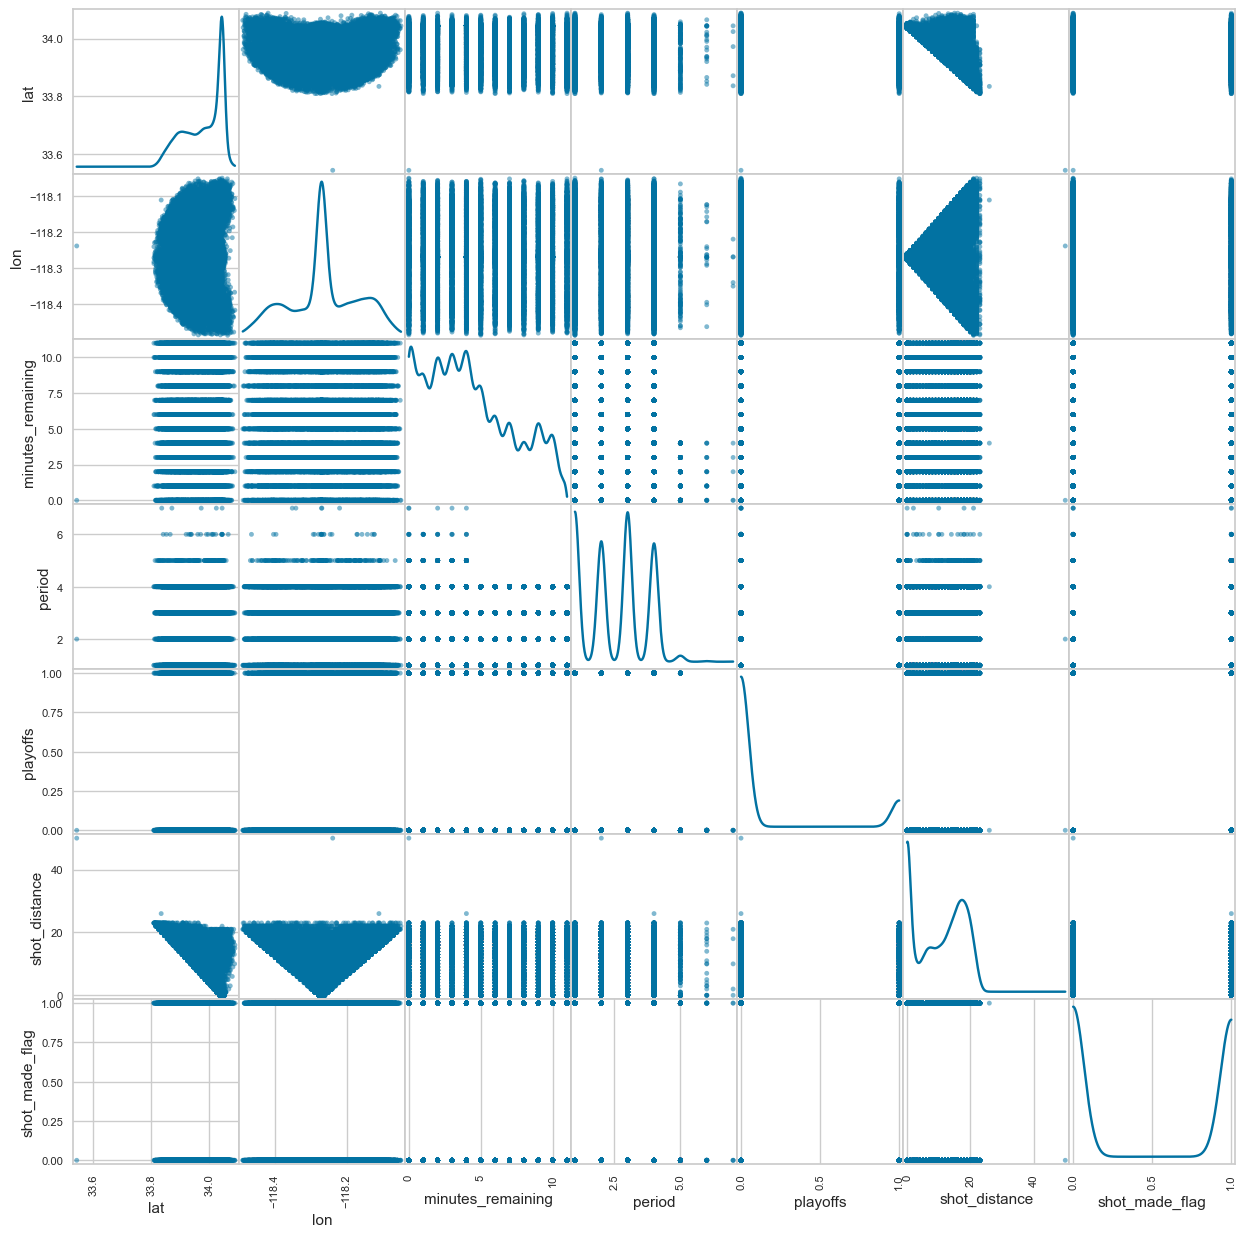

In [4]:
pd.plotting.scatter_matrix(raw_data, diagonal='kde', figsize=(15,15))

In [5]:
cvfold = 10

def plot_parameter_validation_curve(X, Y, param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = X, 
                                                 y = Y, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=cvfold,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    plt.grid(True)
    return plt.gcf()

In [6]:
train_size = 0.8
test_size = 0.2

with mlflow.start_run(experiment_id=exp_id, run_name = 'PreparacaoDados'):
    
    df_dev_filtered = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')
    df_dev_filtered = df_dev_filtered[data_cols].copy()
    df_dev_filtered.dropna(inplace=True)
    df_dev_filtered.to_parquet('../data/processed/data_filtered.parquet')

    x = df_dev_filtered.drop(columns=target_col)
    y = df_dev_filtered[target_col]

    xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=train_size, test_size=test_size, stratify=y, random_state=42)
    
    xtrain[target_col] = ytrain
    xtest[target_col] = ytest
    xtrain.to_parquet('../data/processed/data_train.parquet')
    xtest.to_parquet('../data/processed/data_test.parquet')

    mlflow.log_params({
      'percentage_test': test_size,
      'selected_columns': data_cols
    })
    mlflow.log_metrics({
      'train_size': xtrain.shape[0],
      'test_size': xtest.shape[0]
    })

In [7]:
#mlflow.end_run() #executar quando der erro de run ativo

In [8]:
registered_model_name = 'model_kobe'
nexamples = 5
model_version = -1

with mlflow.start_run(experiment_id=exp_id, run_name = 'Treinamento'):

  exp = pc.setup(
    data = xtrain,
    target = target_col,
    test_data = xtest,
    normalize = True,
    log_experiment = False
  )

  list_models = exp.compare_models(['lr', 'dt'], n_select=2, sort='f1')

  plot_parameter_validation_curve(xtrain.drop(target_col, axis=1), ytrain, 'max_depth', {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}, list_models[0], 'Decision Tree', 'f1', logx=False)
  plt.savefig('vc_decision_tree.png')
  mlflow.log_artifact('vc_decision_tree.png')

  plot_parameter_validation_curve(xtrain.drop(target_col, axis=1), ytrain, 'C', {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, list_models[1], 'Regressão Logística', 'f1', logx=True)
  plt.savefig('vc_logistic_regression.png')
  mlflow.log_artifact('vc_logistic_regression.png')

  yhat_test = exp.predict_model(list_models[0])
  mlflow.log_metrics({
      'log_loss_decision_tree': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
      'f1_decision_tree': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)	
  })

  yhat_test = exp.predict_model(list_models[1])
  mlflow.log_metrics({
      'lr_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
      'lr_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
  })

  tuned_model = exp.tune_model(
    list_models[0],
    optimize='f1',
    search_library='scikit-learn',
    search_algorithm='random',
    n_iter=4
  )

  yhat_test = exp.predict_model(tuned_model, raw_score=True)

  mlflow.log_metrics({
      'log_loss_final_mode': log_loss(yhat_test[target_col], yhat_test.prediction_label),
      'f1_final_model': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)	
  })

  yhat_test.to_parquet('../data/processed/prediction_test.parquet')
  mlflow.log_artifact('../data/processed/prediction_test.parquet')


  final_model = exp.finalize_model(tuned_model)

  pc.save_model(final_model, f'./{registered_model_name}')
  model_pipeline = exp.load_model(f'./{registered_model_name}')
  model_features = list(xtrain.drop(columns=target_col).columns)
  model_signature = infer_signature(xtrain[model_features], model_pipeline.predict_proba(xtrain.drop(columns=target_col)))
  input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
  mlflow.sklearn.log_model(
    sk_model = model_pipeline,
    artifact_path = 'sklearn-model',
    registered_model_name = registered_model_name,
    signature = model_signature,
    input_example = input_example,
    pyfunc_predict_fn = 'predict-proba'
  )
  client = MlflowClient()
  if model_version == -1:
    model_version = client.get_latest_versions(registered_model_name)[-1].version
  client.set_registered_model_alias(
    name = registered_model_name,
    alias = 'staging',
    version = model_version,
    
  )

,Description,Value
0,Session id,1646
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.5336,0.5152,0.5858,0.5100,0.5451,0.0712,0.0720,0.1630
lr,Logistic Regression,0.5785,0.5996,0.4920,0.5674,0.5269,0.1504,0.1517,0.2680


Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8, 9, 10]
Scoring: f1
Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
Scoring: f1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5447,0.5209,0.5942,0.5203,0.5548,0.0932,0.0940


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5714,0.5955,0.4729,0.5606,0.5130,0.1351,0.1367


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5940,0.6087,0.3514,0.6340,0.4522,0.1698,0.1886
1,0.5884,0.5985,0.4380,0.5927,0.5037,0.1655,0.1710
2,0.5921,0.6017,0.4026,0.6106,0.4852,0.1704,0.1806
3,0.5853,0.5865,0.3703,0.6081,0.4603,0.1548,0.1674
4,0.5940,0.5960,0.3394,0.6415,0.4439,0.1694,0.1908
5,0.5779,0.5793,0.4142,0.5815,0.4838,0.1436,0.1495
6,0.5730,0.5596,0.3613,0.5858,0.4469,0.1299,0.1400
7,0.5946,0.5778,0.3755,0.6258,0.4694,0.1733,0.1881
8,0.5832,0.5896,0.4109,0.5911,0.4848,0.1535,0.1606


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5447,0.5209,0.5942,0.5203,0.5548,0.0932,0.0940


2024/04/18 20:12:54 WARNING mlflow.sklearn: Model was missing function: predict-proba. Not logging python_function flavor!


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Successfully registered model 'model_kobe'.
Created version '1' of model 'model_kobe'.


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5447,0.5209,0.5942,0.5203,0.5548,0.0932,0.0940


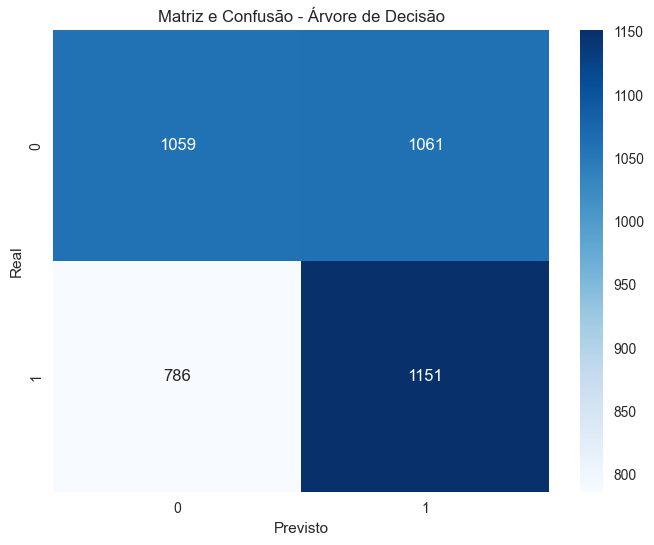

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5714,0.5955,0.4729,0.5606,0.5130,0.1351,0.1367


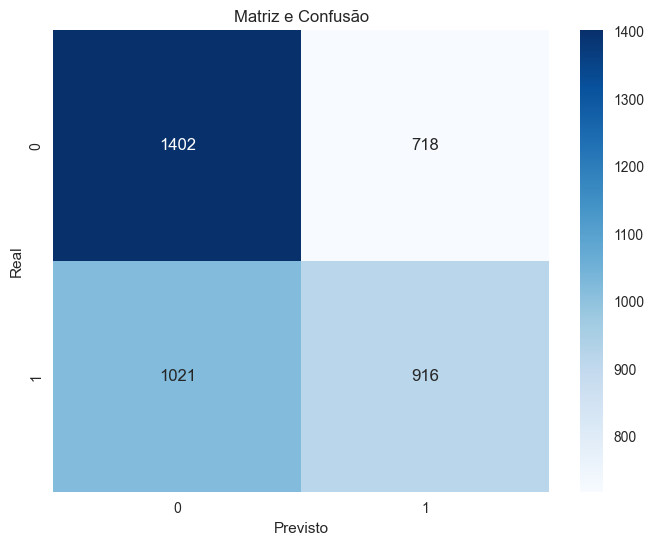

In [9]:
ypred_matrix = exp.predict_model(list_models[0]).prediction_label
ytest_matrix = xtest[target_col]
cm = confusion_matrix(ytest, ypred_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz e Confusão - Árvore de Decisão')
plt.show()

ypred_matrix = exp.predict_model(list_models[1]).prediction_label
ytest_matrix = xtest[target_col]
cm = confusion_matrix(ytest, ypred_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz e Confusão')
plt.show()

           lat       lon  minutes_remaining  period  playoffs  shot_distance
30558  33.8883 -118.3828                 11       3         1             19
520    34.0213 -118.1598                  2       3         0             11
25613  33.9833 -118.1208                 10       2         0             16
15368  34.0443 -118.2698                  0       4         0              0
9175   34.0443 -118.2698                  0       1         0              0
...        ...       ...                ...     ...       ...            ...
323    34.0313 -118.2988                 11       2         0              3
1043   34.0423 -118.1848                  6       1         0              8
23222  34.0443 -118.2698                  3       4         0              0
14718  33.9343 -118.3778                  5       1         0             15
24021  33.8503 -118.2818                  0       1         0             19

[4057 rows x 6 columns]
Top Features
 ['playoffs' 'period' 'lon' 'lat']
['l

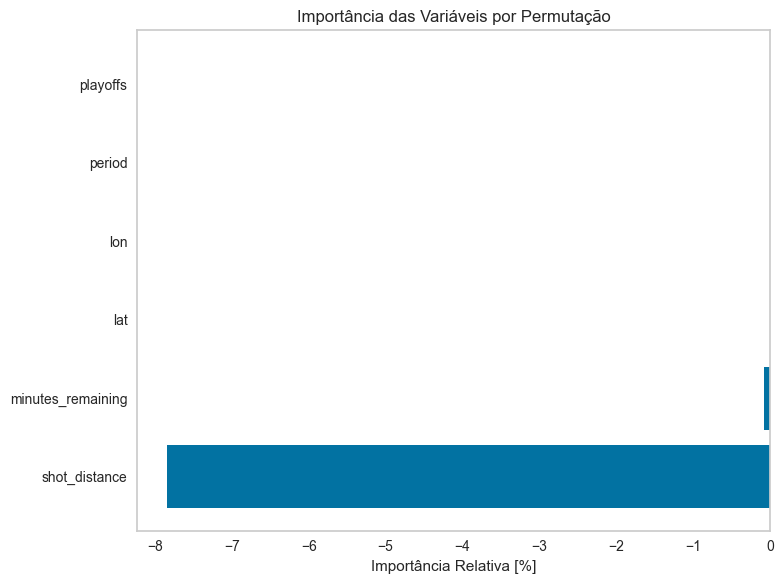

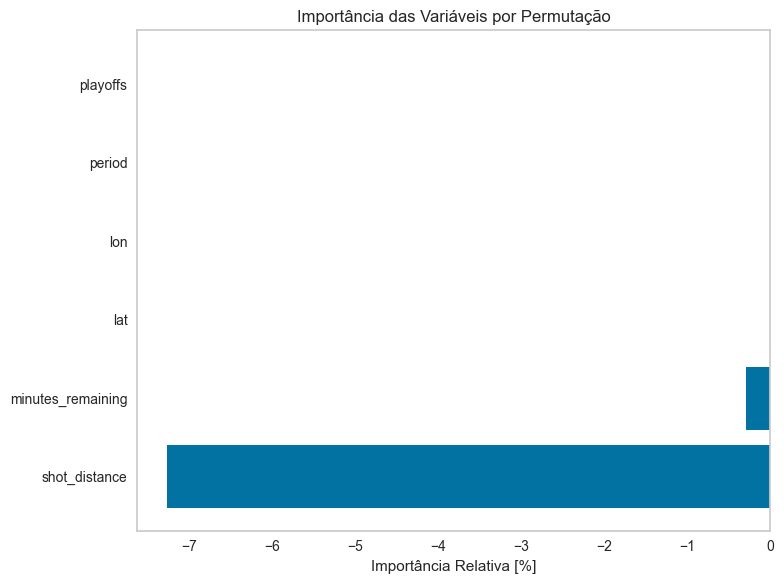

In [10]:
ntop=4

data_cols_permutation = copy.deepcopy(data_cols)
data_cols_permutation.remove(target_col)

xtest_permutartion = copy.deepcopy(xtest)
xtest_permutartion = xtest_permutartion.drop(columns=target_col, axis=1)

print(xtest_permutartion)
plt.figure(figsize=(8,6))

r = permutation_importance(list_models[0], xtest_permutartion, ytest,
                           n_repeats=30,
                           random_state=0)
importance =  r.importances_mean
idx = np.argsort(importance)
plt.barh(np.arange(idx.shape[0]), importance[idx]*100)
plt.yticks(np.arange(idx.shape[0]), np.array(data_cols_permutation)[idx])
plt.title('Importância das Variáveis por Permutação')
plt.grid()
plt.xlabel('Importância Relativa [%]')
plt.tight_layout()

top_features = np.array(data_cols_permutation)[idx][::-1][:ntop]
print('Top Features\n',top_features)


data_cols_permutation = copy.deepcopy(data_cols)
data_cols_permutation.remove(target_col)

print(data_cols_permutation)

xtest_permutartion = copy.deepcopy(xtrain)
xtest_permutartion = xtest_permutartion.drop(columns=target_col, axis=1)

print(xtest_permutartion)
plt.figure(figsize=(8,6))

r = permutation_importance(list_models[0], xtest_permutartion, ytrain,
                           n_repeats=30,
                           random_state=0)
importance =  r.importances_mean
idx = np.argsort(importance)
plt.barh(np.arange(idx.shape[0]), importance[idx]*100)
plt.yticks(np.arange(idx.shape[0]), np.array(data_cols_permutation)[idx])
plt.title('Importância das Variáveis por Permutação')
plt.grid()
plt.xlabel('Importância Relativa [%]')
plt.tight_layout()

top_features = np.array(data_cols_permutation)[idx][::-1][:ntop]
print('Top Features\n',top_features)

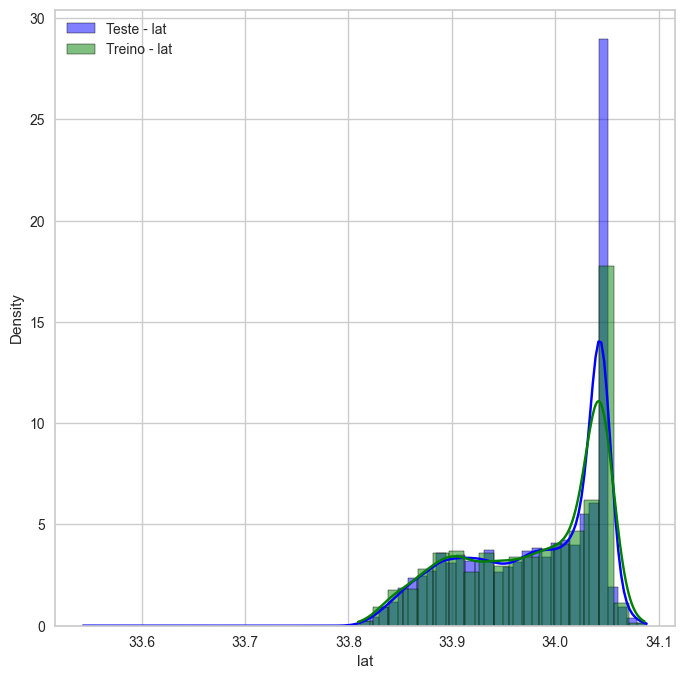

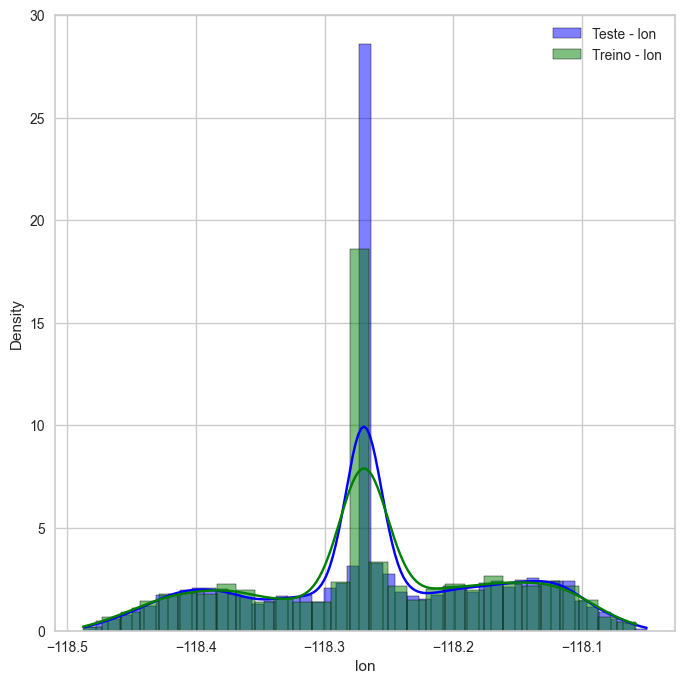

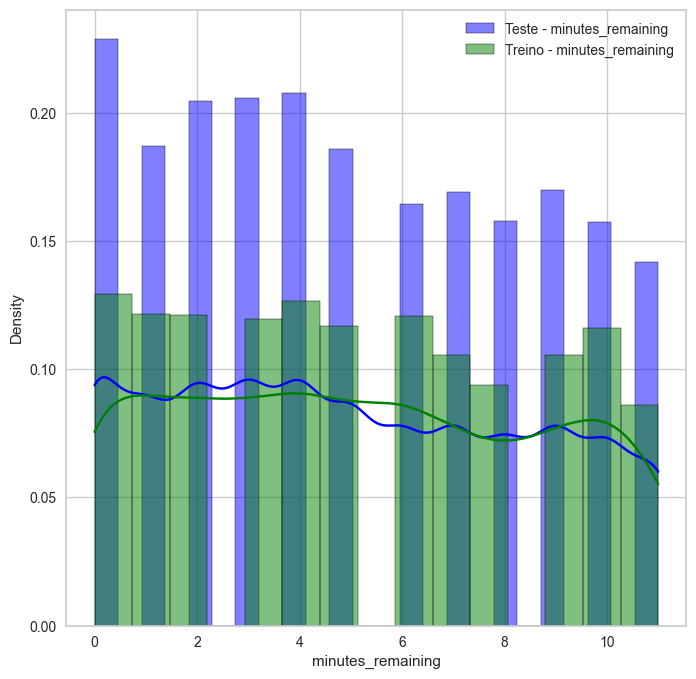

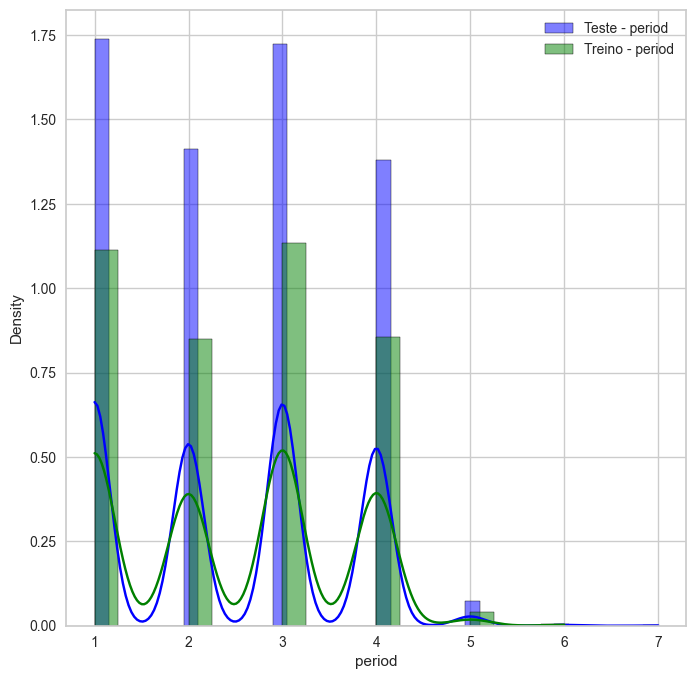

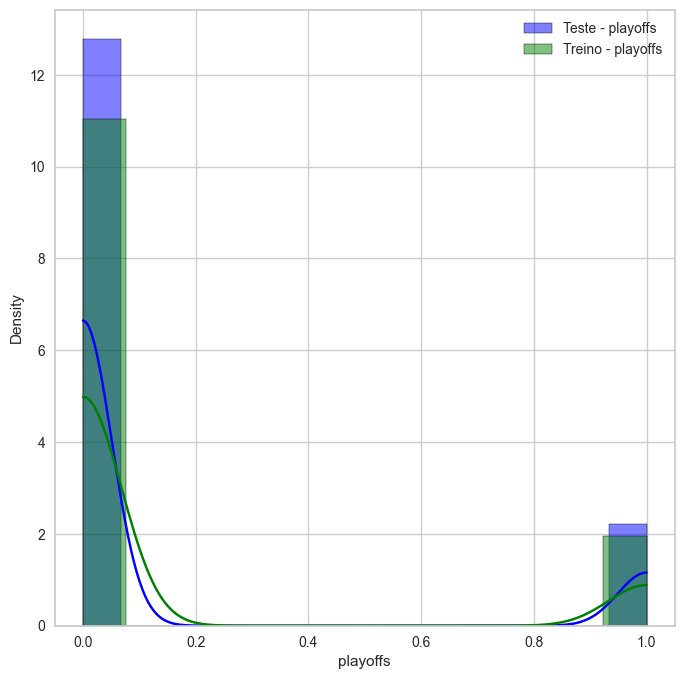

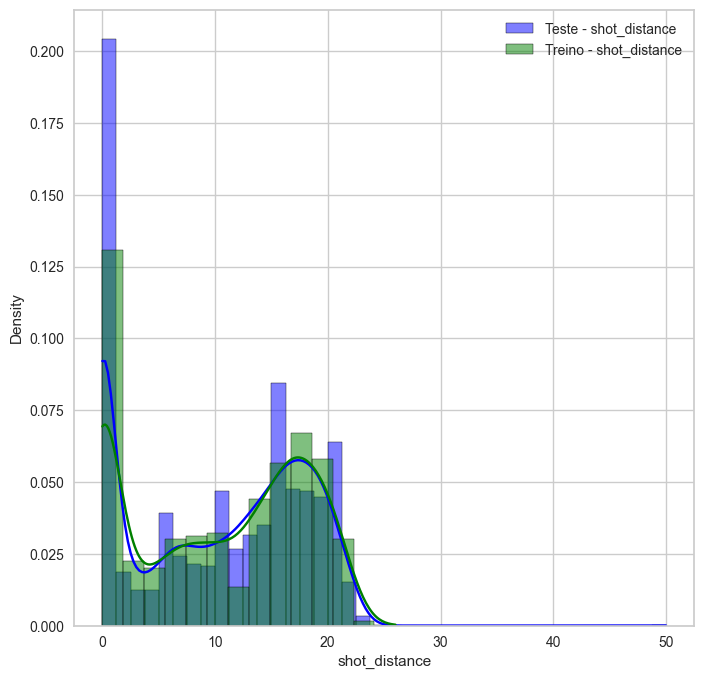

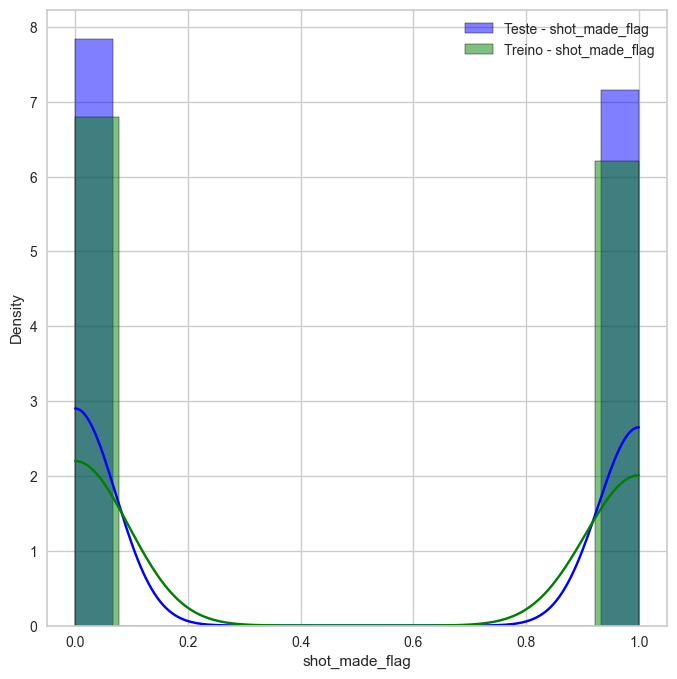

In [11]:
for col in data_cols:
    fig, ax = plt.subplots(figsize=(8, 8))

    sns.histplot(xtrain[col], label=f'Teste - {col}', kde=True, stat='density', ax=ax, color='blue')
    sns.histplot(xtest[col], label=f'Treino - {col}', kde=True, stat='density', ax=ax, color='green')

    ax.legend()

    plt.show()

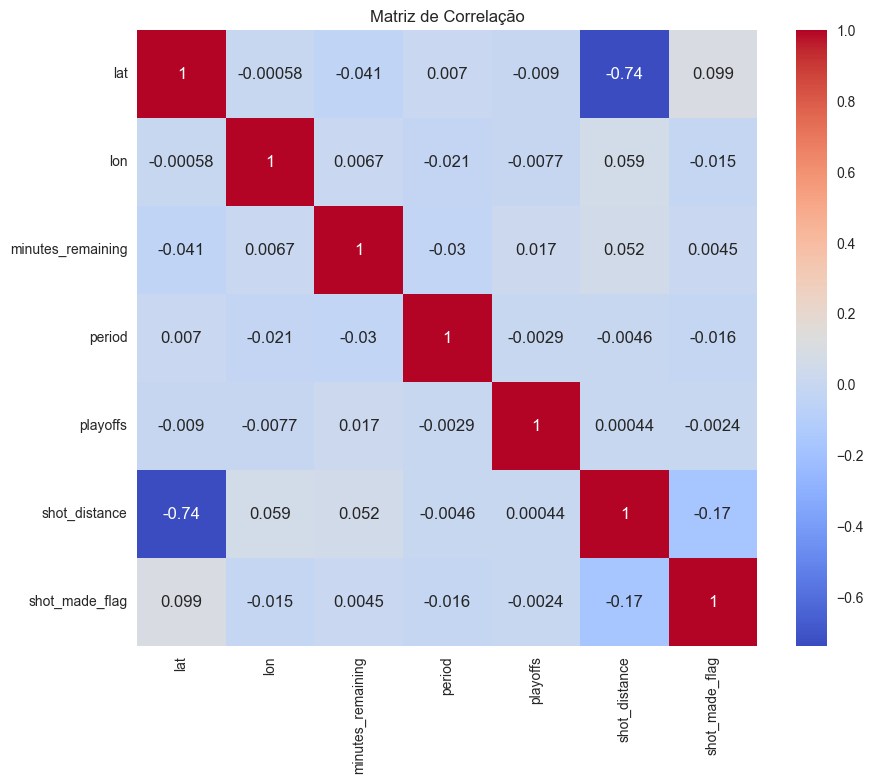

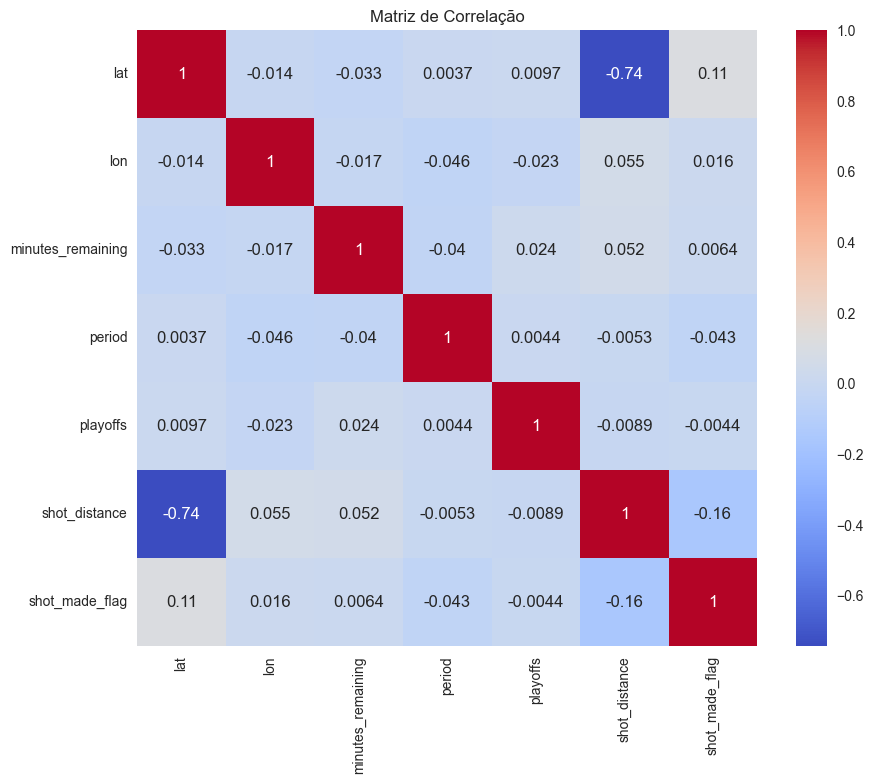

In [12]:
correlation_matrix = xtrain.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

correlation_matrix = xtest.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5447,0.5209,0.5942,0.5203,0.5548,0.0932,0.0940


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5714,0.5955,0.4729,0.5606,0.5130,0.1351,0.1367


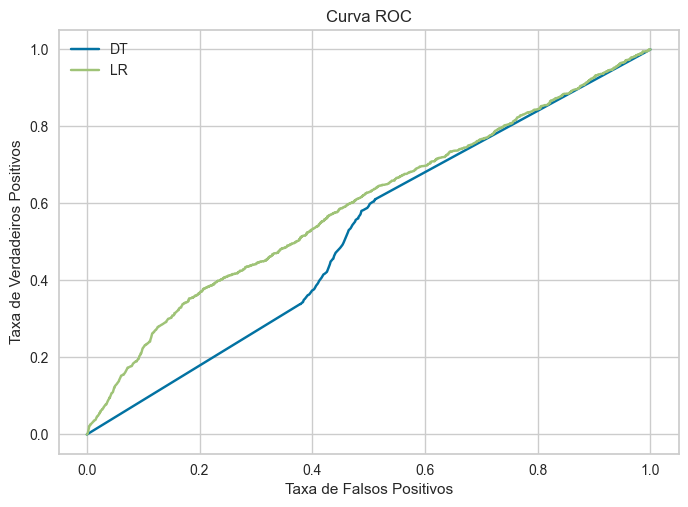

In [13]:
yhat_test_dt = exp.predict_model(list_models[0], raw_score=True)
fpr, tpr, thr = roc_curve(yhat_test_dt[target_col], yhat_test_dt.prediction_score_1)

yhat_test_rl = exp.predict_model(list_models[1], raw_score=True)
fpr2, tpr2, thr2 = roc_curve(yhat_test_rl[target_col], yhat_test_rl.prediction_score_1)

plt.plot(fpr, tpr, label='DT')
plt.plot(fpr2, tpr2, label='LR')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')

plt.legend()